## **Modelling**

---

**Repos**

TOXIFY: https://github.com/tijeco/toxify

ToxClassifier: https://github.com/rgacesa/ToxClassifier

# **0. Setup**

**Mounting Google Drive:**

In [1]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# test for GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# -----------------------------------------------------------------------------
# COMMON IMPORTS

import io
import itertools as ite
import numpy as np
import pandas as pd
import pickle
import os.path
import random
import sklearn
import statistics
import tensorflow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

RANDOM_SEED = 273
random.seed(RANDOM_SEED)

In [4]:
# Change below to path of source code folder
PATH_TO_FOLDER = '/content/drive/My Drive/UoS/Year3/COM3001/Submission/source_code'

In [5]:
# FILEPATHS
# -----------------------------------------------------------------------------

# processed data
f_train_atchley_means = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_atchley_mean.pickle'

# training data
f_train_complete = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_complete.pickle'

f_train_atchley_raw = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_atchley_raw.pickle'
f_train_atchley_diff = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_atchley_diff.pickle'
f_train_atchley_combined = PATH_TO_FOLDER + '/pre_processing_files/dataframes/train_atchley_combined.pickle'

# testing data
f_test_complete = PATH_TO_FOLDER + '/pre_processing_files/dataframes/test_complete.pickle'

f_test_atchley_raw = PATH_TO_FOLDER + '/pre_processing_files/dataframes/test_atchley_raw.pickle'
f_test_atchley_diff = PATH_TO_FOLDER + '/pre_processing_files/dataframes/test_atchley_diff.pickle'
f_test_atchley_combined = PATH_TO_FOLDER + '/pre_processing_files/dataframes/test_atchley_combined.pickle'

In [6]:
# COMMON FUNCTIONS START
# -----------------------------------------------------------------------------

# for writing and reading data to/from a binary file
def pickle_method(fname, method, context):
    if method == 'wb':
        return pickle.dump(context, open(fname, method))
    elif method == 'rb':
        return pickle.load(open(fname, method))

# **1. Loading Pre-Processed datasets**

In [7]:
# unpickling training data with complete atchley method
df_train_combined = pickle_method(f_train_atchley_combined, 'rb', '')
df_train_combined.head(5)

,identifier,toxic,length,sequence,matrix_raw,matrix_diff,f1_raw,f2_raw,f3_raw,f4_raw,f5_raw,atchley_raw_avg,f1_diff,f2_diff,f3_diff,f4_diff,f5_diff,atchley_diff_avg
0,sp|C0HJT4|3NOJ_DENAN,1,63,"[L, E, C, H, R, R, G, S, F, I, S, D, G, K, I, ...","[[-1.019, 1.357, -1.343, 0.336, 1.538, 1.538, ...","[[-1.019, 2.376, -2.7, 1.679, 1.202, 0.0, -1.9...","[-1.019, 1.357, -1.343, 0.336, 1.538, 1.538, -...","[-0.987, -1.453, 0.465, -0.417, -0.055, -0.055...","[-1.505, 1.477, -0.862, -1.673, 1.502, 1.502, ...","[1.266, 0.113, -1.02, -1.474, 0.44, 0.44, 1.04...","[-0.912, -0.837, -0.255, -0.078, 2.897, 2.897,...","[-0.6314, 0.13140000000000002, -0.603, -0.6611...","[-1.019, 2.376, -2.7, 1.679, 1.202, 0.0, -1.92...","[-0.987, -0.4660000000000001, 1.91800000000000...","[-1.505, 2.982, -2.339, -0.811, 3.175, 0.0, -0...","[1.266, -1.153, -1.133, -0.45399999999999996, ...","[-0.912, 0.07500000000000007, 0.582, 0.177, 2....","[-0.6314, 0.7627999999999999, -0.7343999999999..."
1,sp|C0HJR6|VSP2_CRODO,1,29,"[T, A, L, P, Q, L, R, L, P, A, T, S, R, I, L, ...","[[-0.032, -0.591, -1.019, 0.189, 0.931, -1.019...","[[-0.032, -0.5589999999999999, -0.427999999999...","[-0.032, -0.591, -1.019, 0.189, 0.931, -1.019,...","[0.326, -1.302, -0.987, 2.081, -0.179, -0.987,...","[2.213, -0.733, -1.505, -1.628, -3.005, -1.505...","[0.908, 1.57, 1.266, 0.421, -0.503, 1.266, 0.4...","[1.313, -0.146, -0.912, -1.392, -1.853, -0.912...","[0.9456, -0.24039999999999995, -0.6314, -0.065...","[-0.032, -0.5589999999999999, -0.4279999999999...","[0.326, -1.6280000000000001, 0.315000000000000...","[2.213, -2.946, -0.7719999999999999, -0.123, -...","[0.908, 0.662, -0.30400000000000005, -0.845, -...","[1.313, -1.4589999999999999, -0.766, -0.479999...","[0.9456, -1.1860000000000002, -0.3909999999999..."
2,sp|A0A0S4FKT4|VSP1_CRODO,1,238,"[V, I, G, G, D, E, C, N, I, N, E, H, N, F, L, ...","[[-1.337, -1.239, -0.384, -0.384, 1.05, 1.357,...","[[-1.337, 0.09799999999999986, 0.8550000000000...","[-1.337, -1.239, -0.384, -0.384, 1.05, 1.357, ...","[-0.279, -0.547, 1.652, 1.652, 0.302, -1.453, ...","[-0.544, 2.131, 1.33, 1.33, -3.656, 1.477, -0....","[1.242, 0.393, 1.045, 1.045, -0.259, 0.113, -1...","[-1.262, 0.816, 2.064, 2.064, -3.242, -0.837, ...","[-0.43600000000000005, 0.31079999999999997, 1....","[-1.337, 0.09799999999999986, 0.85500000000000...","[-0.279, -0.268, 2.199, 0.0, -1.34999999999999...","[-0.544, 2.675, -0.8009999999999997, 0.0, -4.9...","[1.242, -0.849, 0.6519999999999999, 0.0, -1.30...","[-1.262, 2.078, 1.2480000000000002, 0.0, -5.30...","[-0.43600000000000005, 0.7468, 0.8306000000000..."
3,sp|C0HK05|PA2BC_CROOL,1,47,"[H, L, L, Q, F, N, K, M, I, K, F, E, T, R, K, ...","[[0.336, -1.019, -1.019, 0.931, -1.006, 0.945,...","[[0.336, -1.355, 0.0, 1.95, -1.937, 1.951, 0.8...","[0.336, -1.019, -1.019, 0.931, -1.006, 0.945, ...","[-0.417, -0.987, -0.987, -0.179, -0.59, 0.828,...","[-1.673, -1.505, -1.505, -3.005, 1.891, 1.299,...","[-1.474, 1.266, 1.266, -0.503, -0.397, -0.169,...","[-0.078, -0.912, -0.912, -1.853, 0.412, 0.933,...","[-0.6611999999999999, -0.6314, -0.6314, -0.921...","[0.336, -1.355, 0.0, 1.95, -1.937, 1.951, 0.88...","[-0.417, -0.5700000000000001, 0.0, 0.808, -0.4...","[-1.673, 0.16800000000000015, 0.0, -1.5, 4.896...","[-1.474, 2.74, 0.0, -1.7690000000000001, 0.105...","[-0.078, -0.8340000000000001, 0.0, -0.941, 2.2...","[-0.6611999999999999, 0.02980000000000005, 0.0..."
4,sp|P0DL64|HPR3_THRPR,1,33,"[D, C, L, K, F, G, W, K, C, N, P, R, N, D, K, ...","[[1.05, -1.343, -1.019, 1.831, -1.006, -0.384,...","[[1.05, -2.393, 0.32400000000000007, 2.8499999...","[1.05, -1.343, -1.019, 1.831, -1.006, -0.384, ...","[0.302, 0.465, -0.987, -0.561, -0.59, 1.652, 0...","[-3.656, -0.862, -1.505, 0.533, 1.891, 1.33, 0...","[-0.259, -1.02, 1.266, -0.277, -0.397, 1.045, ...","[-3.242, -0.255, -0.912, 1.648, 0.412, 2.064, ...","[-1.161, -0.603, -0.6314, 0.6347999999999999, ...","[1.05, -2.393, 0.32400000000000007, 2.84999999...","[0.302, 0.16300000000000003, -1.452, 0.4259999..

In [8]:
# unpickling testing data with complete atchley method
df_test_combined = pickle_method(f_test_atchley_combined, 'rb', '')
df_test_combined.head(5)

,identifier,toxic,length,sequence,matrix_raw,matrix_diff,f1_raw,f2_raw,f3_raw,f4_raw,f5_raw,atchley_raw_avg,f1_diff,f2_diff,f3_diff,f4_diff,f5_diff,atchley_diff_avg
0,sp|C0HLB8|PA2_MICLE,1,32,"[N, R, N, N, R, D, W, W, H, F, A, D, Y, G, C, ...","[[0.945, 1.538, 0.945, 0.945, 1.538, 1.05, -0....","[[0.945, 0.5930000000000001, -0.59300000000000...","[0.945, 1.538, 0.945, 0.945, 1.538, 1.05, -0.5...","[0.828, -0.055, 0.828, 0.828, -0.055, 0.302, 0...","[1.299, 1.502, 1.299, 1.299, 1.502, -3.656, 0....","[-0.169, 0.44, -0.169, -0.169, 0.44, -0.259, -...","[0.933, 2.897, 0.933, 0.933, 2.897, -3.242, -0...","[0.7672000000000001, 1.2644, 0.767200000000000...","[0.945, 0.5930000000000001, -0.593000000000000...","[0.828, -0.883, 0.883, 0.0, -0.883, 0.357, -0....","[1.299, 0.20300000000000007, -0.20300000000000...","[-0.169, 0.609, -0.609, 0.0, 0.609, -0.6990000...","[0.933, 1.9639999999999997, -1.963999999999999...","[0.7672000000000001, 0.4972, -0.4972, 0.0, 0.4..."
1,sp|A0A1P8NVR5|COW1_CONAO,1,63,"[M, G, K, L, T, I, L, V, L, V, A, A, I, L, L, ...","[[-0.663, -0.384, 1.831, -1.019, -0.032, -1.23...","[[-0.663, 0.279, 2.215, -2.8499999999999996, 0...","[-0.663, -0.384, 1.831, -1.019, -0.032, -1.239...","[-1.524, 1.652, -0.561, -0.987, 0.326, -0.547,...","[2.219, 1.33, 0.533, -1.505, 2.213, 2.131, -1....","[-1.005, 1.045, -0.277, 1.266, 0.908, 0.393, 1...","[1.212, 2.064, 1.648, -0.912, 1.313, 0.816, -0...","[0.04779999999999993, 1.1414, 0.63479999999999...","[-0.663, 0.279, 2.215, -2.8499999999999996, 0....","[-1.524, 3.176, -2.213, -0.42599999999999993, ...","[2.219, -0.8889999999999998, -0.797, -2.038, 3...","[-1.005, 2.05, -1.322, 1.5430000000000001, -0....","[1.212, 0.8520000000000001, -0.416000000000000...","[0.04779999999999993, 1.0936, -0.5066, -1.2662..."
2,sp|F5C3T9|COW_CONVR,1,63,"[M, G, K, L, T, I, L, V, L, V, A, A, V, L, L, ...","[[-0.663, -0.384, 1.831, -1.019, -0.032, -1.23...","[[-0.663, 0.279, 2.215, -2.8499999999999996, 0...","[-0.663, -0.384, 1.831, -1.019, -0.032, -1.239...","[-1.524, 1.652, -0.561, -0.987, 0.326, -0.547,...","[2.219, 1.33, 0.533, -1.505, 2.213, 2.131, -1....","[-1.005, 1.045, -0.277, 1.266, 0.908, 0.393, 1...","[1.212, 2.064, 1.648, -0.912, 1.313, 0.816, -0...","[0.04779999999999993, 1.1414, 0.63479999999999...","[-0.663, 0.279, 2.215, -2.8499999999999996, 0....","[-1.524, 3.176, -2.213, -0.42599999999999993, ...","[2.219, -0.8889999999999998, -0.797, -2.038, 3...","[-1.005, 2.05, -1.322, 1.5430000000000001, -0....","[1.212, 0.8520000000000001, -0.416000000000000...","[0.04779999999999993, 1.0936, -0.5066, -1.2662..."
3,sp|A0A1P8NVU0|COW2_CONBL,1,60,"[M, G, K, L, T, I, L, V, L, V, A, A, V, L, L, ...","[[-0.663, -0.384, 1.831, -1.019, -0.032, -1.23...","[[-0.663, 0.279, 2.215, -2.8499999999999996, 0...","[-0.663, -0.384, 1.831, -1.019, -0.032, -1.239...","[-1.524, 1.652, -0.561, -0.987, 0.326, -0.547,...","[2.219, 1.33, 0.533, -1.505, 2.213, 2.131, -1....","[-1.005, 1.045, -0.277, 1.266, 0.908, 0.393, 1...","[1.212, 2.064, 1.648, -0.912, 1.313, 0.816, -0...","[0.04779999999999993, 1.1414, 0.63479999999999...","[-0.663, 0.279, 2.215, -2.8499999999999996, 0....","[-1.524, 3.176, -2.213, -0.42599999999999993, ...","[2.219, -0.8889999999999998, -0.797, -2.038, 3...","[-1.005, 2.05, -1.322, 1.5430000000000001, -0....","[1.212, 0.8520000000000001, -0.416000000000000...","[0.04779999999999993, 1.0936, -0.5066, -1.2662..."
4,sp|A0A1P8NVR4|COW2_CONLI,1,61,"[M, E, K, L, T, M, L, V, L, V, A, A, V, L, L, ...","[[-0.663, 1.357, 1.831, -1.019, -0.032, -0.663...","[[-0.663, 2.02, 0.474, -2.8499999999999996, 0....","[-0.663, 1.357, 1.831, -1.019, -0.032, -0.663,...","[-1.524, -1.453, -0.561, -0.987, 0.326, -1.524...","[2.219, 1.477, 0.533, -1.505, 2.213, 2.219, -1...","[-1.005, 0.113, -0.277, 1.266, 0.908, -1.005, ...","[1.212, -0.837, 1.648, -0.912, 1.313, 1.212, -...","[0.04779999999999993, 0.13140000000000002, 0.6...","[-0.663, 2.02, 0.474, -2.8499999999999996, 0.9...","[-1.524, 0.07099999999999995, 0.892, -0.4259

# **2. Training vs Validation splitting**

In [9]:
# -----------------------------------------------------------------------------
# SPLITTING IMPORTS

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [10]:
# Acquiring training data features and label
# and splitting training set into training and validation sets
y_train_labels = df_train_combined['toxic']
x_train_features_raw = df_train_combined['matrix_raw']
x_train_features_diff = df_train_combined['matrix_diff']

In [11]:
# Acquiring testing data features and label
y_test_labels = df_test_combined['toxic']
x_test_features_raw = df_test_combined['matrix_raw']
x_test_features_diff = df_test_combined['matrix_diff']

In [12]:
# Converting the dataframes into an array in preparation for re-shaping later on

# training data
train_features_array_raw = np.array(x_train_features_raw.to_list())
train_features_array_diff = np.array(x_train_features_diff.to_list())

# testing data
test_features_array_raw = np.array(x_test_features_raw.to_list())
test_features_array_diff = np.array(x_test_features_diff.to_list())

In [13]:
# Reshaping X_traning features for both raw and different Atchley value matrices
X_train_raw = train_features_array_raw.reshape(11792, 5, 500, 1)
X_train_diff = train_features_array_diff.reshape(11792, 5, 500, 1)

# Printing shapes for confirmation
print(f'Training features - Raw Atchley values shape:       {X_train_raw.shape}')
print(f'Training features - Change in Atchley values shape: {X_train_diff.shape}')

Training features - Raw Atchley values shape:       (11792, 5, 500, 1)
Training features - Change in Atchley values shape: (11792, 5, 500, 1)


In [14]:
# Reshaping X_test features for both raw and different Atchley value matrices
X_test_raw = test_features_array_raw.reshape(333, 5, 500, 1)
X_test_diff = test_features_array_diff.reshape(333, 5, 500, 1)

# Printing shapes for confirmation
print(f'Testing features - Raw Atchley values shape:       {X_test_raw.shape}')
print(f'Testing features - Change in Atchley values shape: {X_test_diff.shape}')

Testing features - Raw Atchley values shape:       (333, 5, 500, 1)
Testing features - Change in Atchley values shape: (333, 5, 500, 1)


In [15]:
# Training and testing labels
y_train = to_categorical(y_train_labels, 2)
print(f'Training labels shape: {y_train.shape}')

y_test = to_categorical(y_test_labels, 2)
print(f'Testing labels shape:  {y_test.shape}')

Training labels shape: (11792, 2)
Testing labels shape:  (333, 2)


# **3. Modelling**

In [16]:
# -----------------------------------------------------------------------------
# COMMON IMPORTS

import multiprocessing

from IPython.display import Image

from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.layers import Conv1D, Conv2D, Embedding, Flatten, GlobalMaxPooling1D
from keras.layers import GRU, MaxPooling1D, SpatialDropout1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.utils.vis_utils import model_to_dot

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [17]:
# MODELLING FUNCTIONS START
# -----------------------------------------------------------------------------
# fit model to data
def fit_model(model, k_folds_dict):
  scores = []
  i = 1
  for fold in k_folds_dict:
    fitted_model = model.fit(k_folds_dict[fold][0], k_folds_dict[fold][2])
    score = accuracy_score(k_folds_dict[fold][3], fitted_model.predict(k_folds_dict[fold][1]))
    print('{} of k-fold {}'.format(fold, len(k_folds_dict)), ' --> ROC AUC score:', score)
    scores.append(score) 
    i += 1
  mean_score = statistics.mean(scores)
  print("\nMean model score: %.3f" % mean_score)
  return mean_score


# run model, save results to dictionary
def run_model(model, k_folds_dicts, filename):
  model_results = {}
  for key, value in k_folds_dicts.items():
    print('\nCV:', key)
    model_results[key] = fit_model_to_folds(model, value)
  pickle_method(filename, 'wb', model_results)
  return model_results

# run all models, save results to a dictionary of dictionaries
def run_all_models(models, k_fold_dicts):
  models_dict = {}
  for model in models:
    print('\nModel:', model)
    models_dict[model] = run_model(model)
  return models_dict

# **3.1 Complex Modelling**

**CNN Model**

In [19]:
# Common state model variables
EPOCHS = 50
BATCH_SIZE = 128
VAL_SIZE = 0.1

In [20]:
# enabling callbacks so model stops in case validation loss keeps increasing
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')]

In [22]:
# CNN neural network architecture
model_cnn = Sequential()

# first hidden layer:
model_cnn.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(5, 500, 1)))

# second hidden layer
model_cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(1,1)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())

# third hidden layer
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))

# output layer
model_cnn.add(Dense(2, activation='sigmoid'))

In [23]:
# Summary of CNN model
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 498, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 496, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 496, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 496, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 31744)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4063360   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [24]:
# compiling CNN model
model_cnn.compile(loss='binary_crossentropy', optimizer='nadam', metrics='accuracy')

In [25]:
# CNN using raw magnitude Atchley values
m_cnn_hist_raw = model_cnn.fit(X_train_raw, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                       verbose=1, validation_split=VAL_SIZE)

Epoch 1/50
83/83 [==============================] - 1s 17ms/step - loss: 0.3034 - accuracy: 0.8839 - val_loss: 0.1831 - val_accuracy: 0.9356
Epoch 2/50
83/83 [==============================] - 1s 13ms/step - loss: 0.1481 - accuracy: 0.9496 - val_loss: 0.0812 - val_accuracy: 0.9653
Epoch 3/50
83/83 [==============================] - 1s 13ms/step - loss: 0.1002 - accuracy: 0.9680 - val_loss: 0.2237 - val_accuracy: 0.9220
Epoch 4/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0672 - accuracy: 0.9774 - val_loss: 0.1126 - val_accuracy: 0.9593
Epoch 5/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0521 - accuracy: 0.9812 - val_loss: 0.1797 - val_accuracy: 0.9424
Epoch 6/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0415 - accuracy: 0.9870 - val_loss: 0.0846 - val_accuracy: 0.9669
Epoch 7/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0318 - accuracy: 0.9887 - val_loss: 0.1255 - val_accuracy: 0.9610
Epoch 8/50
83

In [26]:
# CNN using sequential differences in Atchley values
m_cnn_hist_diff = model_cnn.fit(X_train_raw, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                       verbose=1, validation_split=VAL_SIZE)

Epoch 1/50
83/83 [==============================] - 1s 15ms/step - loss: 0.0033 - accuracy: 0.9985 - val_loss: 0.2128 - val_accuracy: 0.9712
Epoch 2/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.1907 - val_accuracy: 0.9797
Epoch 3/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 0.2830 - val_accuracy: 0.9644
Epoch 4/50
83/83 [==============================] - 1s 13ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.3261 - val_accuracy: 0.9593
Epoch 5/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.2153 - val_accuracy: 0.9712
Epoch 6/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0026 - accuracy: 0.9988 - val_loss: 0.3290 - val_accuracy: 0.9585
Epoch 7/50
83/83 [==============================] - 1s 14ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.2297 - val_accuracy: 0.9703
Epoch 8/50
83

In [27]:
# GRAPHING FUNCTION
import matplotlib.pyplot as plt
import seaborn as sns

# plots graphs from model history
def plot_model_training(model_hist, model_name, type_plot, x_dim, y_dim):
  sns.set()
  fig = plt.subplots(figsize=(x_dim, y_dim))
  if type_plot == 'loss':
    plt.title(str(model_name) + ' Loss')
    plt.plot(model_hist.history['loss'], label='train')
    plt.plot(model_hist.history['val_loss'], label='val')
    plt.ylabel('Training loss')
  if type_plot == 'acc':
    plt.title(str(model_name) + ' Accuracy')
    plt.plot(model_hist.history['accuracy'], label='train')
    plt.plot(model_hist.history['val_accuracy'], label='val')
    plt.ylabel('Training accuracy')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
xdim = 18
ydim = 8

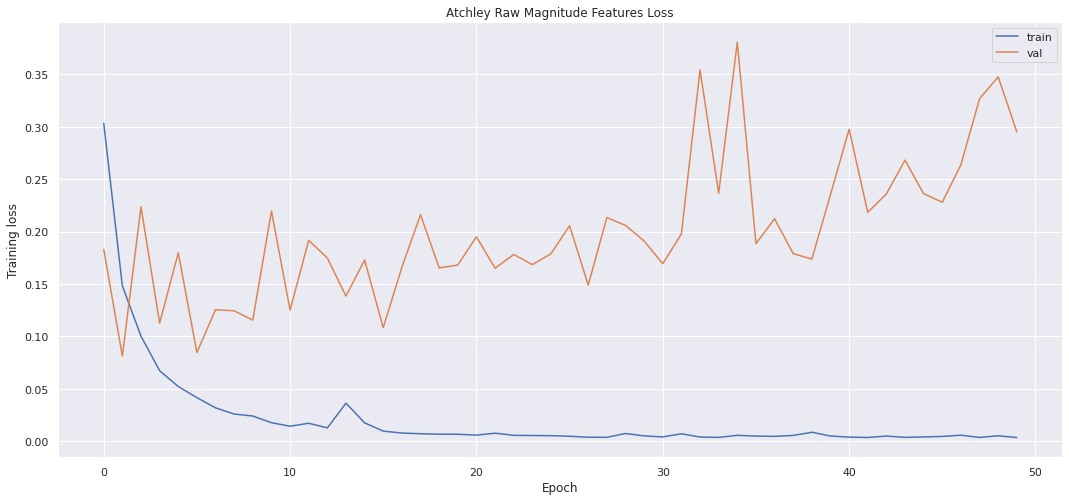

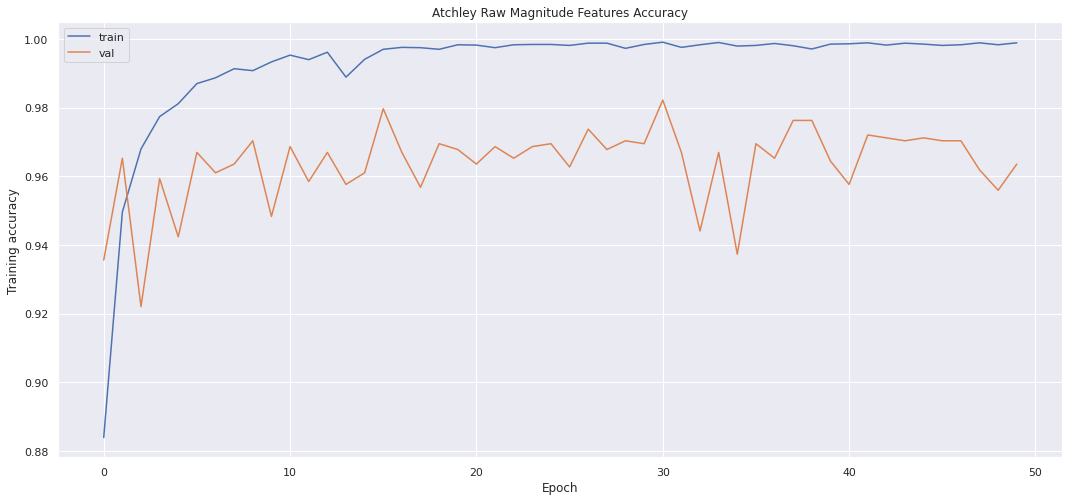

In [30]:
# plotting Atchley raw model loss and accuracy
title_raw = 'Atchley Raw Magnitude Features'
plot_model_training(m_cnn_hist_raw, title_raw, 'loss', xdim, ydim)
plot_model_training(m_cnn_hist_raw, title_raw, 'acc', xdim, ydim)

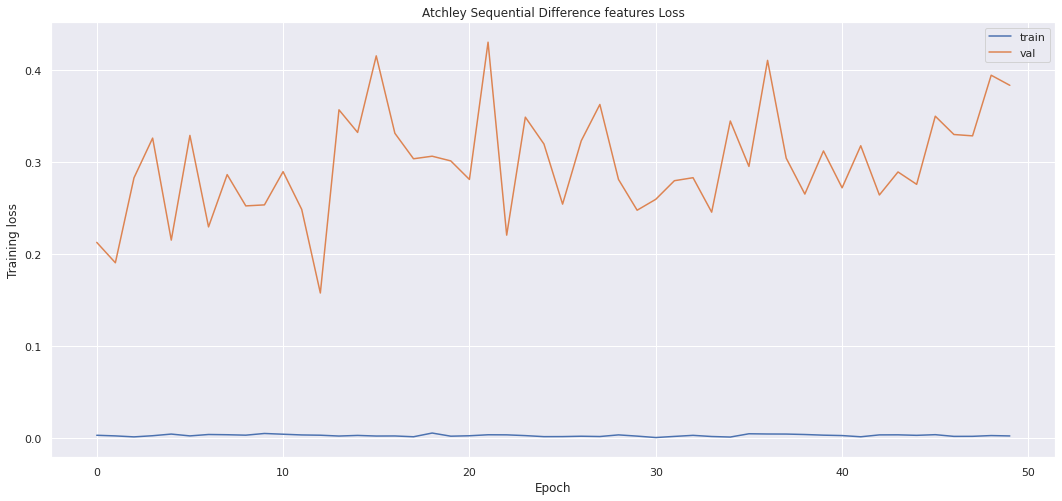

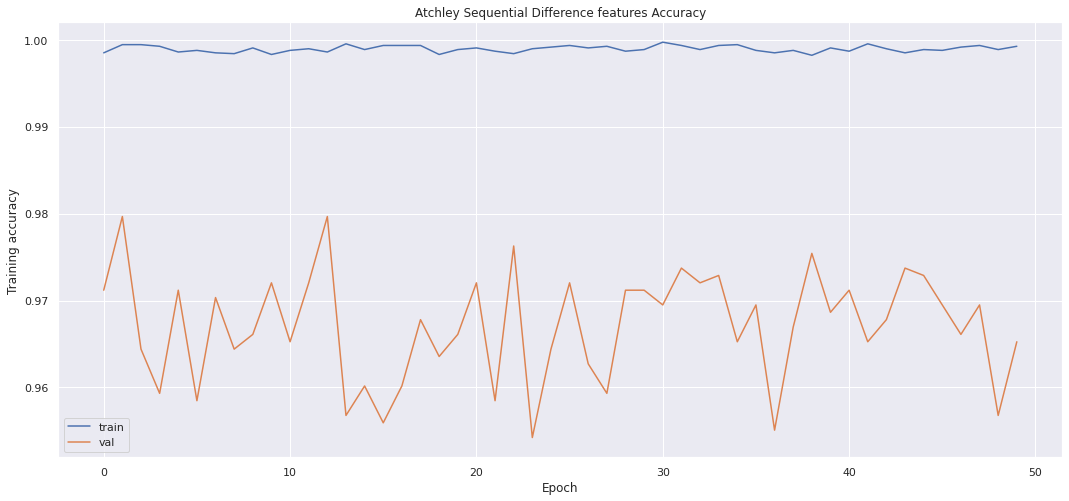

In [31]:
# plotting Atchley raw model loss and accuracy
title_diff = 'Atchley Sequential Difference features'
plot_model_training(m_cnn_hist_diff, title_diff, 'loss', xdim, ydim)
plot_model_training(m_cnn_hist_diff, title_diff, 'acc', xdim, ydim)

**Predicting on test data**

In [32]:
# CNN with raw magnitude of Atchley values as features
m_cnn_hist_raw_score = model_cnn.evaluate(X_test_raw, y_test, verbose=1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(m_cnn_hist_raw_score[0], m_cnn_hist_raw_score[1]))

11/11 [==============================] - 0s 4ms/step - loss: 1.0308 - accuracy: 0.9309
Test set
  Loss: 1.031
  Accuracy: 0.931


In [33]:
# CNN with sequential change of Atchley values as features
m_cnn_hist_diff_score = model_cnn.evaluate(X_test_diff, y_test, verbose=1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(m_cnn_hist_diff_score[0], m_cnn_hist_diff_score[1]))

11/11 [==============================] - 0s 3ms/step - loss: 2.1532 - accuracy: 0.8198
Test set
  Loss: 2.153
  Accuracy: 0.820
